# Step 1.2 - Add bikecounts to the Copenhagen carall Network
## Project: Growing Urban Bicycle Networks

This notebook loads bikecounter data from Copenhagen in 2019, and applies a fraction of bikecounts to the nearest edges in the carall network. For streets (which are composed by one or several edges in the network), which are given bikecount, the mean of these bikecounts are assigned to the whole street, to generalise the data. 
a bikecount attribute 'bcount_attr' is added to the network, represented as edgelength multiplied with the fraction of the mean of bikecounts for the given street.
For edges that are not assigned this attribute, the average edgelength multiplied with the average bikecount in the network, is assigned.
Contact: Michael Szell (michael.szell@gmail.com)  
Created: 2020-06-09  
Last modified: 2021-03-10

## Preliminaries

### Parameters

In [23]:
debug = True # If True, will produce plots and/or verbose output to double-check
%run -i "../parameters/parameters.py"

Loaded parameters.



### Setup

In [24]:
%run -i path.py
#%run -i setup.py
%run -i setupCPH.py
import pandas as pd
from sklearn import preprocessing
%load_ext watermark
%watermark -n -v -m -g -iv
import statistics

Loaded PATH.

Setup finished.

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.8.2
IPython version      : 8.5.0

Compiler    : Clang 9.0.1 
OS          : Darwin
Release     : 18.7.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

Git hash: b795eaefba9eb6349c319ca07997ebd31e033f57

sklearn   : 1.1.2
igraph    : 0.9.1
sys       : 3.8.2 | packaged by conda-forge | (default, Apr 24 2020, 07:56:27) 
[Clang 9.0.1 ]
numpy     : 1.23.3
fiona     : 1.8.21
networkx  : 2.8.6
matplotlib: 3.6.0
geopandas : 0.11.1
osmnx     : 0.16.2
osgeo     : 3.2.1
watermark : 2.3.1
pandas    : 1.4.4
shapely   : 1.8.4
geojson   : 2.5.0
csv       : 1.0
pyproj    : 3.4.0



### Functions

In [25]:
%run -i functions.py

Loaded functions.



## Load carall graph

In [26]:
G_carall = ox.load_graphml('../../bikenwgrowth_external/data/copenhagen/bikedata/G_carall_graphml.graphml')

## Load bike traffic data, convert to fractions and normalise


In [27]:
#Load bike data
count_df = pd.read_csv("../../bikenwgrowth_external/data/copenhagen/bikedata/bicycle_counts.csv")
count_df = count_df[count_df.year ==2019]
bikelanes = gpd.GeoDataFrame(count_df, geometry=gpd.points_from_xy(count_df['long'], count_df['lat']))

#convert to fraction. All bikecounts are added 1 to avoid division by zero (if zero bikes).
count_df['bcount_attr']= count_df['bicycle_count']
for i in range(len(count_df)):
    count_df['bcount_attr'].iloc[i] = 1.0/float(count_df['bicycle_count'].iloc[i]+1)

#Normalise bikecounts in range 0.1 to 1 to avoid zero values


x = count_df.drop(count_df.columns[[0,1,2,3,4,5,6]], axis=1) #returns a numpy array of only bikecounts
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0.1, 1.0))
x_scaled = min_max_scaler.fit_transform(x)
bike_norm_df = pd.DataFrame(x_scaled)

#update count_df with normalised values

for i in range(len(count_df)):
    count_df['bcount_attr'].iloc[i] = bike_norm_df.iloc[i]

/var/folders/r8/tq2ln28d2vg5b08rjdywrcvc0000gn/T/ipykernel_40422/306599767.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  count_df['bcount_attr'].iloc[i] = 1.0/float(count_df['bicycle_count'].iloc[i]+1)


## Add 'bcount_attr' to carall graph

In [28]:
#We create a variable for unassigned edges, 
# which is the average edgelength multiplied with the average bikecount in the network

mean_bcount_attr = count_df['bcount_attr'].mean()

edges_len_dict = nx.get_edge_attributes(G_carall, 'length')
edges_len_mean = statistics.mean([k for k in edges_len_dict.values()])
bcount_attr_unassigned = edges_len_mean*mean_bcount_attr

#we set the bcount_attr to 0 initially

nx.set_edge_attributes(G_carall, 0.0, 'bcount_attr')

#We apply bikecounts from our data to the nearest edges in the carall network
for i in range(len(count_df)):
    ne = ox.distance.get_nearest_edge(G_carall, [count_df.iloc[i].lat,count_df.iloc[i].long])
    nx.set_edge_attributes(G_carall, {ne: {'bcount_attr': count_df.iloc[i].bcount_attr }})

    
# a dictionary of each of the two new attributes in the G_carall graph is generated and saved. 
bcount_attr_dict = nx.get_edge_attributes(G_carall, "bcount_attr")

ox_to_csv(G_carall, PATH["data"] + 'copenhagen' + "/", 'copenhagen', 'carall')

ox_to_csv(ox.simplify_graph(G_carall), PATH["data"] + 'copenhagen' + "/", 'copenhagen', 'carall', "_simplified")

copenhagen: Successfully wrote graph carall
copenhagen: Successfully wrote graph carall_simplified


## Plot bikecounters and nearest edges

/Users/Kristof/opt/anaconda3/envs/OSMNX/lib/python3.8/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


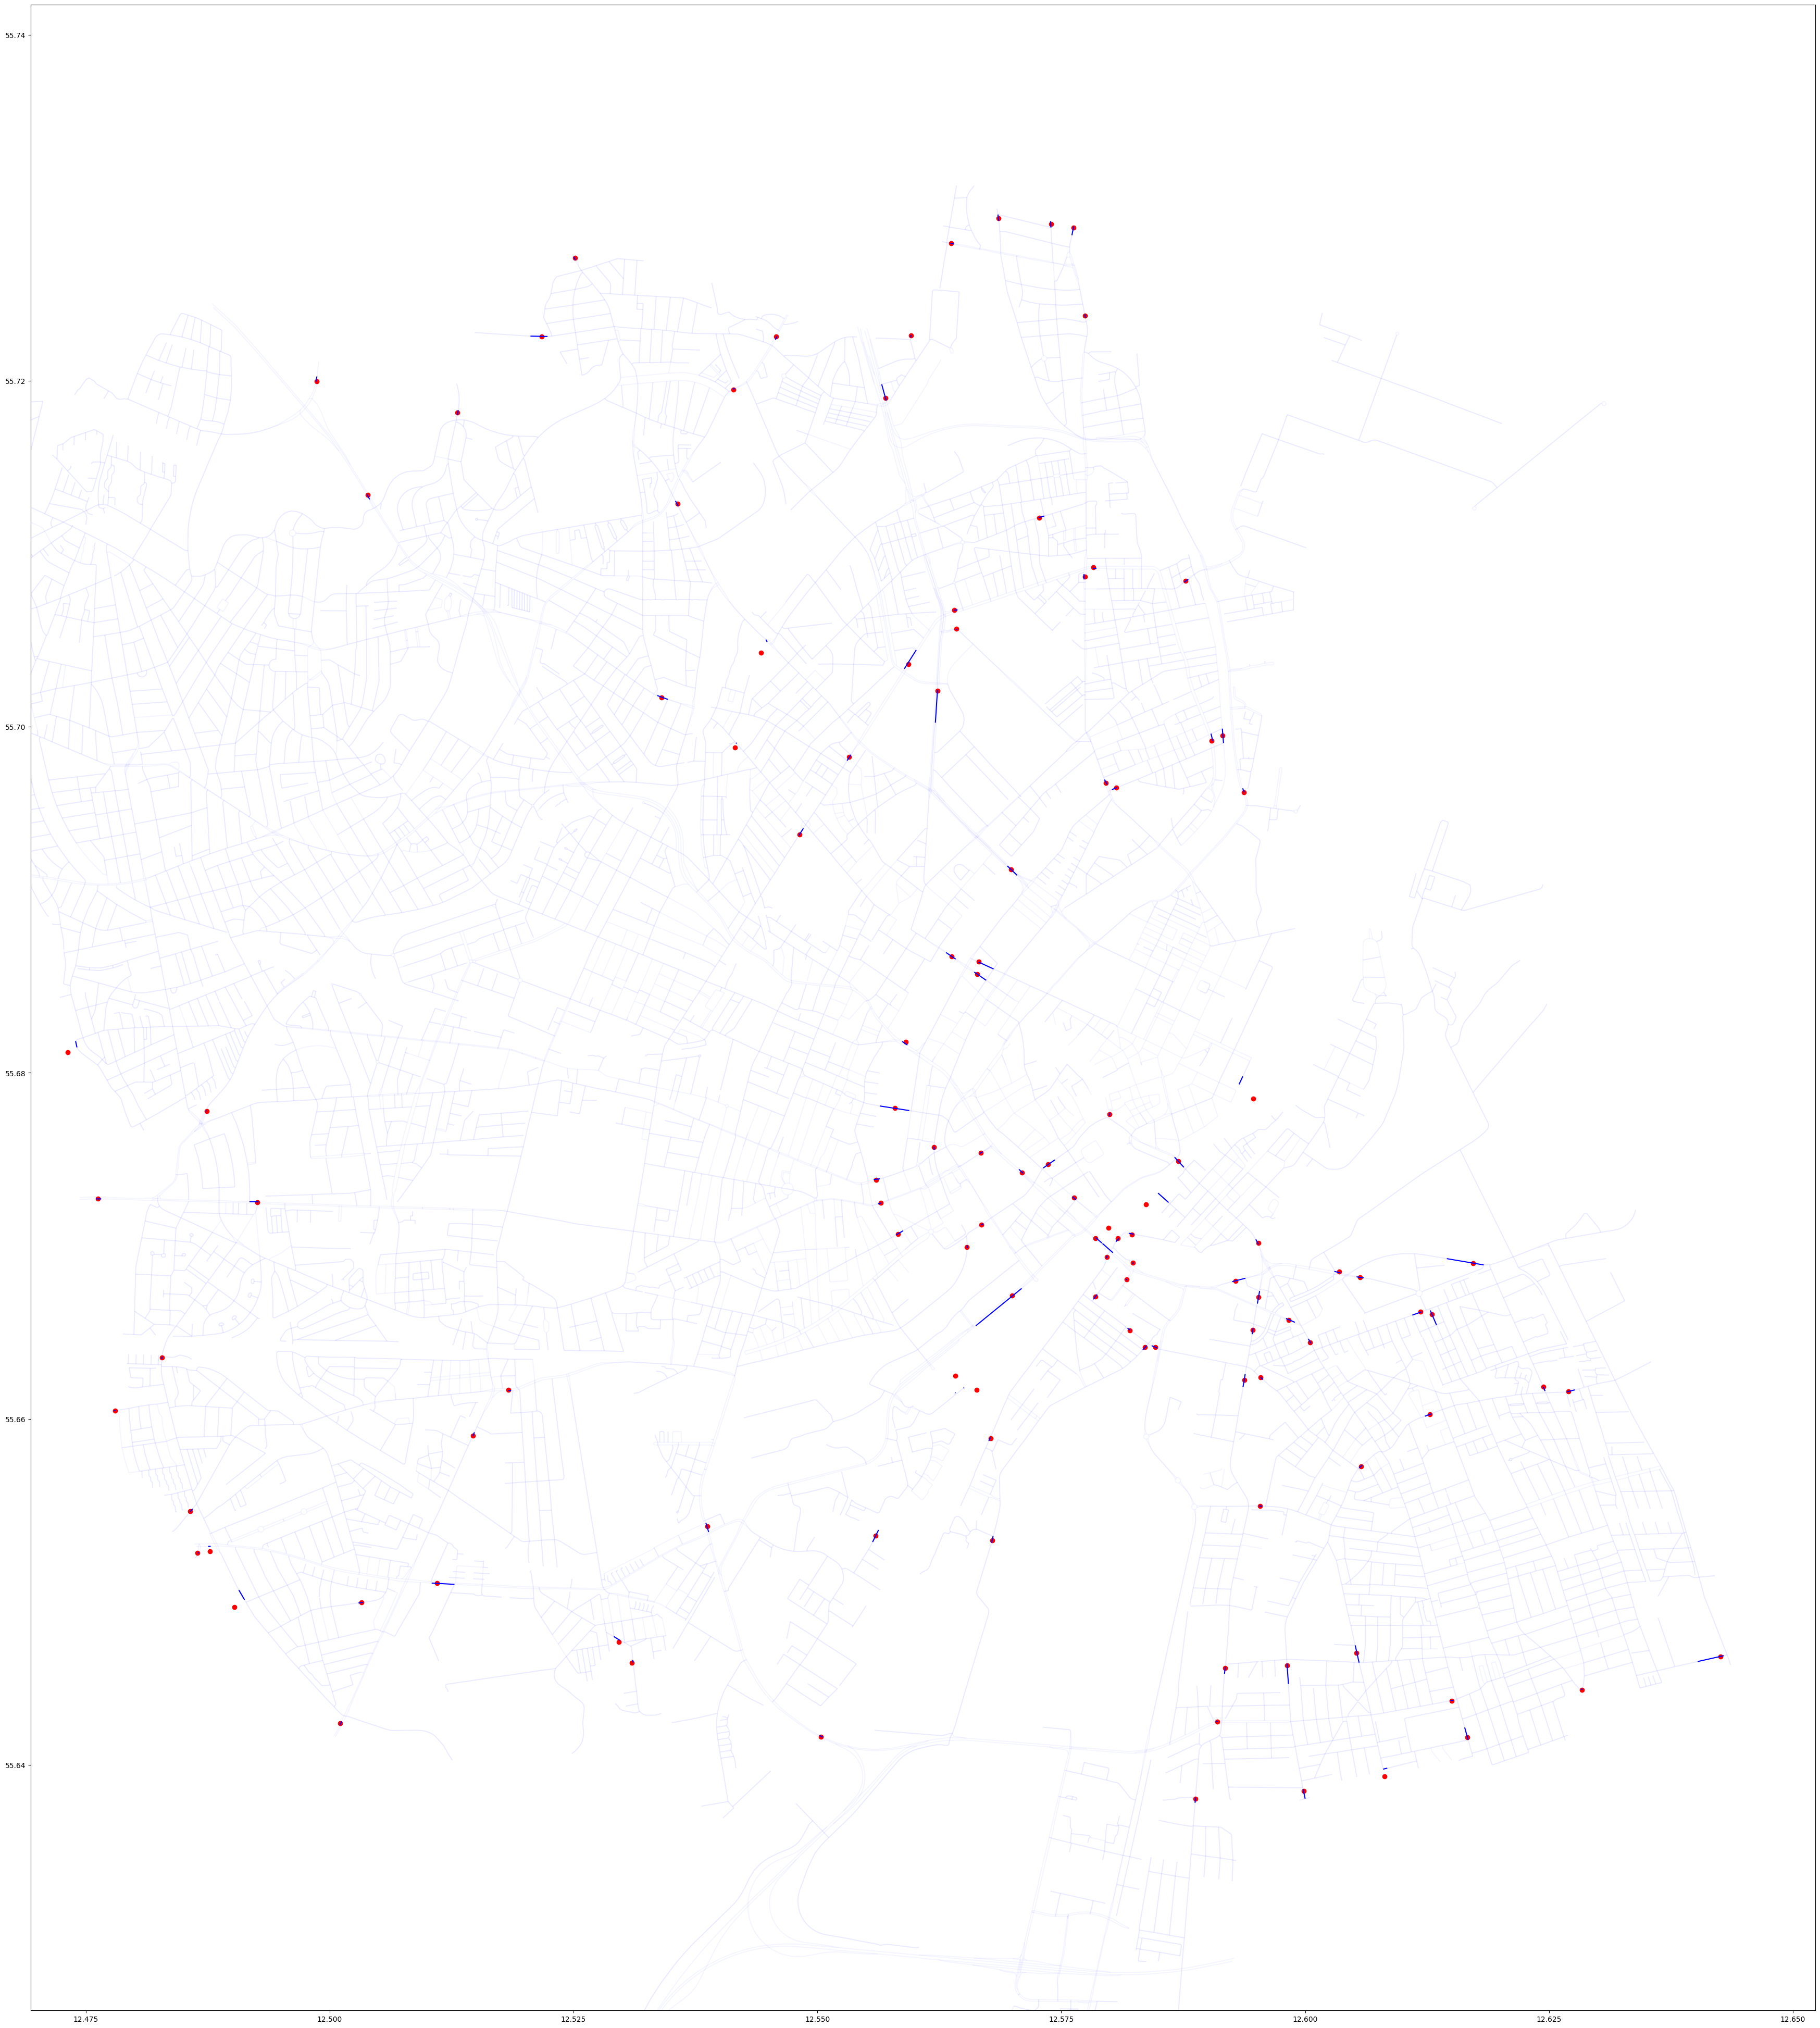

In [29]:
lanes = ox.graph_to_gdfs(G_carall, nodes=False) 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ac = [0.04 if (bcount_attr_dict[k]) == 0.0 else 1.0 for k in bcount_attr_dict]
ax = world[world.name == "Copenhagen municipality"].plot(color='black', edgecolor='black', figsize=(50,50),bgcolor = 'black')
bikelanes.plot(ax=ax, color='red')
lanes.plot(ax=ax, color='blue', alpha= ac)
#bikelanes2.plot(ax=ax, color='red', alpha = 0.3,linestyle=(0,(5,10)))
plt.axis([12.469380, 12.652281, 55.625802, 55.741728])
plt.show()

## Generalise bikecounts to whole streets

In [30]:
with zipfile.ZipFile("../../bikenwgrowth_external/data/copenhagen/copenhagen_carall_edges.zip", 'r') as zip_ref:
    zip_ref.extractall("../../bikenwgrowth_external/data/copenhagen/")

edges = pd.read_csv("../../bikenwgrowth_external/data/copenhagen/copenhagen_carall_edges.csv")

GG_carall = copy.deepcopy(G_carall)

edges = pd.read_csv("../../bikenwgrowth_external/data/copenhagen/copenhagen_carall_edges.csv")

#We take only assigned edges
edges1 = edges[edges.bcount_attr !=0.0]

#we remove unnecessery data
edges2 = edges1.drop(edges1.columns[[1,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18]], axis=1)

#we apply the mean of bikecounts for all assigned streets, by grouping on the street name and calculating the mean.
edges3 = edges2.groupby('name')['bcount_attr'].mean().to_frame()

#renaming this column
edges3 = edges3.rename(columns={"bcount_attr": "mean_group_bcount"})

#the initial edges are joined with the new generalised counts
result = pd.merge(edges,edges3,on='name',how = 'left')

result.to_csv("../../bikenwgrowth_external/data/copenhagen/copenhagen_carall_edges.csv")

compress_file("../../bikenwgrowth_external/data/copenhagen/","copenhagen_carall_edges")

/var/folders/r8/tq2ln28d2vg5b08rjdywrcvc0000gn/T/ipykernel_40422/2603673803.py:4: DtypeWarning: Columns (9,10,11,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  edges = pd.read_csv("../../bikenwgrowth_external/data/copenhagen/copenhagen_carall_edges.csv")
/var/folders/r8/tq2ln28d2vg5b08rjdywrcvc0000gn/T/ipykernel_40422/2603673803.py:8: DtypeWarning: Columns (9,10,11,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  edges = pd.read_csv("../../bikenwgrowth_external/data/copenhagen/copenhagen_carall_edges.csv")


## Apply edge attribute after generalisation

In [31]:
result2 = result

#we apply the 'bcount_attr' the the result2 dataframe, representing all edges in the carall network.
# for edges that 'still' do not have a bikecount, a standard value is assigned 'bcount_attr_unassigned',
# otherwise the new mean fraction of bikecounts for each edge, is multiplied with the length of this edge.
# For now we lost the original fraction of bikecounts for assigned edges, but we will add them back in next step.
for i in range(len(result2)):
    num = result2['mean_group_bcount'].iloc[i]
    #if num is NaN
    if num != num:
        result2['mean_group_bcount'].iloc[i]= bcount_attr_unassigned
    else:
        result2['mean_group_bcount'].iloc[i]= num *result2['length'].iloc[i]

# The new results are added to the carall network,
i=-1
for e in GG_carall.edges():
    i+=1
    a,b=e
    old_bcount_attr = GG_carall.get_edge_data(a,b,0)['bcount_attr']
    # if the edge is initially unassigned in the network we check if a generalised mean value of the whole street, 
    #belonging to this street exist, otherwise a standard value is given. If an edge is initially assigned a bikecount
    # we assign it the bcount_attr again, represented as edgelength multiplied by the fraction of bikecounts.
    if old_bcount_attr ==0.0:
        if  result2['mean_group_bcount'].iloc[i] == bcount_attr_unassigned:
            nx.set_edge_attributes(GG_carall, {(a,b,0): {"bcount_attr": bcount_attr_unassigned }})
        else:
            edgelength = GG_carall.get_edge_data(a,b,0)['length']
            mean_group_count = result2['mean_group_bcount'].iloc[i]
            nx.set_edge_attributes(GG_carall, {(a,b,0): {"bcount_attr": mean_group_count }})
    else:
        edgelength = GG_carall.get_edge_data(a,b,0)['length']
        bcountattr = old_bcount_attr* edgelength
        nx.set_edge_attributes(GG_carall, {(a,b,0): {"bcount_attr": bcountattr }})

bcount_attr_dict = nx.get_edge_attributes(GG_carall, "bcount_attr")
bcount_attr_dict

ox_to_csv(GG_carall, PATH["data"] + 'copenhagen' + "/", 'copenhagen', 'carall')

ox_to_csv(ox.simplify_graph(GG_carall), PATH["data"] + 'copenhagen' + "/", 'copenhagen', 'carall', "_simplified")

ox.save_graphml(GG_carall, "../../bikenwgrowth_external/data/copenhagen/bikedata/G_carall_graphml.graphml")

with open('../../bikenwgrowth_external/data/copenhagen/bikedata/edges_dict_bcount_attr.pkl', 'wb') as f:
    pickle.dump(bcount_attr_dict, f)

/var/folders/r8/tq2ln28d2vg5b08rjdywrcvc0000gn/T/ipykernel_40422/2580212278.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result2['mean_group_bcount'].iloc[i]= bcount_attr_unassigned
/var/folders/r8/tq2ln28d2vg5b08rjdywrcvc0000gn/T/ipykernel_40422/2580212278.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result2['mean_group_bcount'].iloc[i]= num *result2['length'].iloc[i]


copenhagen: Successfully wrote graph carall
copenhagen: Successfully wrote graph carall_simplified


## Plot updated edges

/Users/Kristof/opt/anaconda3/envs/OSMNX/lib/python3.8/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


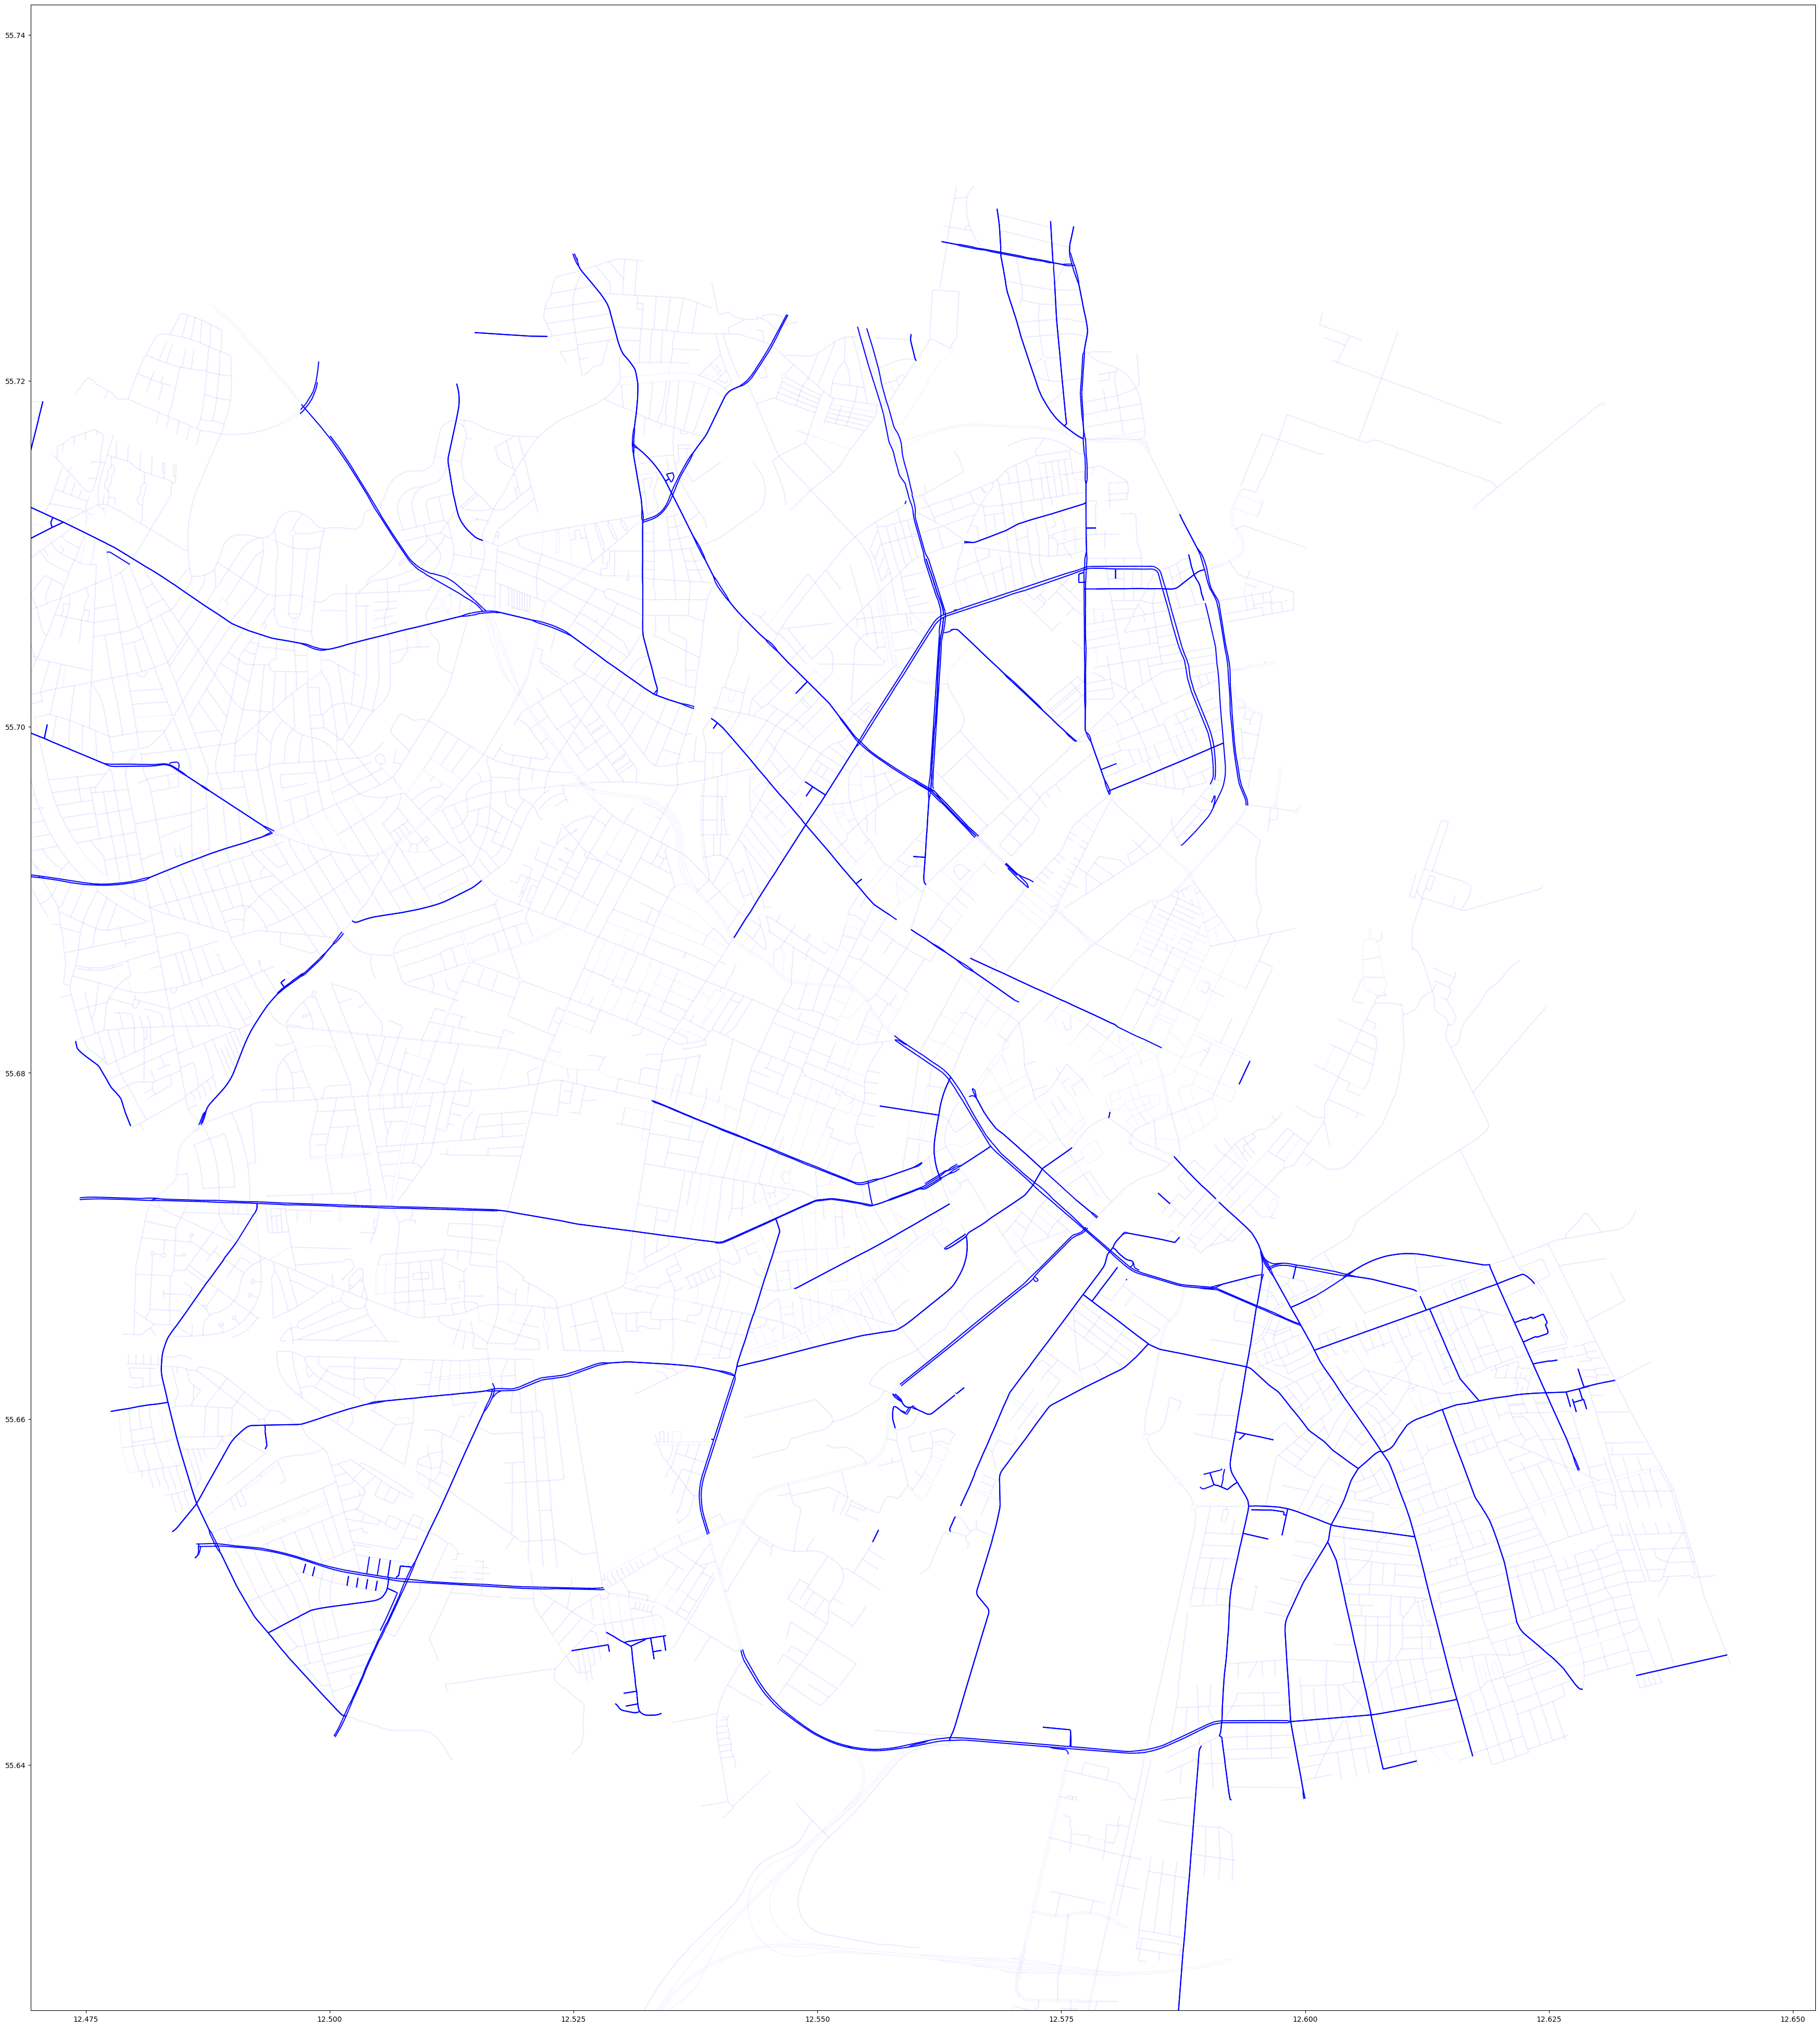

In [32]:
lanes = ox.graph_to_gdfs(GG_carall, nodes=False)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ac = [0.04 if (bcount_attr_dict[k]) == bcount_attr_unassigned else 1.0 for k in bcount_attr_dict]

ax = world[world.name == "Copenhagen municipality"].plot(color='black', edgecolor='black', figsize=(50,50),bgcolor = 'black')
#bikelanes.plot(ax=ax, color='red')
lanes.plot(ax=ax, color='blue', alpha= ac)
#bikelanes2.plot(ax=ax, color='red', alpha = 0.3,linestyle=(0,(5,10)))



plt.axis([12.469380, 12.652281, 55.625802, 55.741728])


plt.show()

In [33]:
Audio(sound_file, autoplay=True)